In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pickle

In [3]:
data_type = "every"
action_trace = 0  # choose from [0, 1, 3, 5, 7, 9] where 0 corresponds to no trace and larger value means longer-term averaging

In [4]:
with open(f"./models/{data_type}{action_trace}_GP_model.pickle", "rb") as f:
    GP_model = pickle.load(f)

/home/lolanff/plant-rl/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/lolanff/plant-rl/.venv/lib/python3.12/site-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


In [5]:
test_area = np.linspace(0, 800, 100)
tests = [
    np.vstack([[area] + np.squeeze(np.eye(1, 3, i)).tolist() for area in test_area])
    for i in range(3)
]
Mean = []
Std = []
for i in range(3):
    predictive_mean, predictive_std = GP_model.predict_mean_std(tests[i])
    Mean.append(predictive_mean)
    Std.append(predictive_std)

/home/lolanff/plant-rl/.venv/lib/python3.12/site-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)
/home/lolanff/plant-rl/.venv/lib/python3.12/site-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


/tmp/ipykernel_2387/919385550.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


(100.0, 650.0)

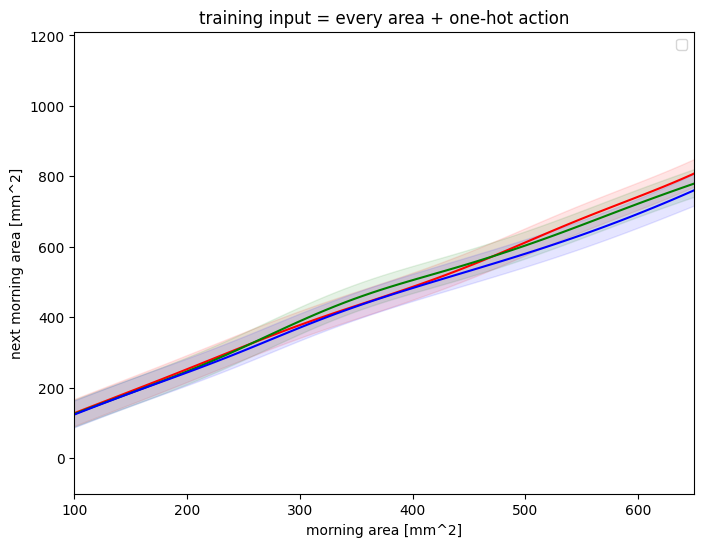

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))
COLORS = ["r", "g", "b"]
for i in range(3):
    ax.plot(test_area, Mean[i], color=COLORS[i])
    ax.fill_between(
        test_area.squeeze(),
        Mean[i] - 1 * Std[i],
        Mean[i] + 1 * Std[i],
        alpha=0.1,
        color=COLORS[i],
    )
ax.set_xlabel("morning area [mm^2]")
ax.set_ylabel("next morning area [mm^2]")
ax.set_title(f"training input = {data_type} area + one-hot action")
ax.legend()
ax.set_xlim([100, 650])
# ax.set_ylim([100., 750])

In [ ]:
policies = [
    [np.squeeze(np.eye(1, 3, i)).tolist() for day in range(14)] for i in range(3)
]
COLORS = ["r", "g", "b"]
LABELS = ["always red", "always white", "always blue"]
AREA_CURVES = []
for i, policy in enumerate(policies):
    area = 30
    area_record = [area]
    for lighting in policy:
        input = np.array([area_record[-1]] + lighting).reshape(1, -1)
        predictive_mean, predictive_std = GP_model.predict_mean_std(input)
        area_record.append(predictive_mean[0])
    plt.plot(np.arange(1, 16), area_record, color=COLORS[i], label=LABELS[i])
plt.legend()
plt.xlabel("day")
plt.ylabel("morning area [mm^2]")

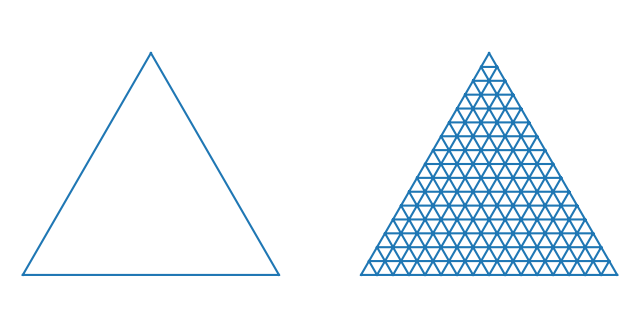

In [ ]:
import matplotlib.tri as tri

corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
AREA = 0.5 * 1 * 0.75**0.5
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])
refiner = tri.UniformTriRefiner(triangle)
trimesh = refiner.refine_triangulation(subdiv=4)
trimesh.set_mask

plt.figure(figsize=(8, 4))
for i, mesh in enumerate((triangle, trimesh)):
    plt.subplot(1, 2, i + 1)
    plt.triplot(mesh)
    plt.axis("off")
    plt.axis("equal")

In [ ]:
# For each corner of the triangle, the pair of other corners
pairs = [corners[np.roll(range(3), -i)[1:]] for i in range(3)]
# The area of the triangle formed by point xy and another pair or points
tri_area = lambda xy, pair: 0.5 * np.linalg.norm(np.cross(*(pair - xy)))


def xy2bc(xy, tol=1.0e-4):
    """Converts 2D Cartesian coordinates to barycentric."""
    coords = np.array([tri_area(xy, p) for p in pairs]) / AREA
    return np.clip(coords, tol, 1.0 - tol)


coord = [xy2bc(xy) for xy in zip(trimesh.x, trimesh.y)]
len(coord)

In [ ]:
# Fix input area, sample lighting using the triangle grid above
test_area = [200, 350, 550]
tests = [
    np.vstack([[test_area[i]] + lighting.tolist() for lighting in coord])
    for i in range(3)
]
Mean = []
Std = []
for i in range(3):
    predictive_mean, predictive_std = GP_model.predict_mean_std(tests[i])
    Mean.append(predictive_mean)
    Std.append(predictive_std)

/tmp/ipykernel_186139/167550638.py:4: UserWarning: The following kwargs were not used by contour: 'nlevels'
  plt.tricontourf(trimesh, Mean[i], nlevels=200, cmap='Purples')


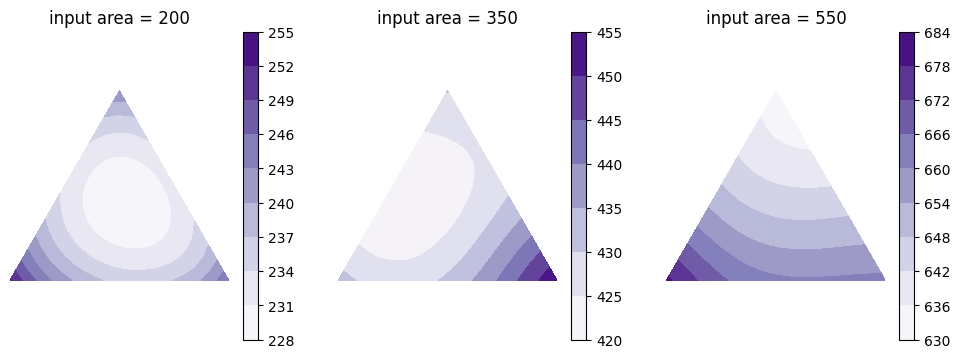

In [ ]:
plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.tricontourf(trimesh, Mean[i], nlevels=200, cmap="Purples")
    plt.colorbar()
    plt.title(f"input area = {test_area[i]}")
    plt.axis("equal")
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis("off")